In [15]:
import initialize_notebook

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

import io
from ams import config
from sklearn.preprocessing import StandardScaler
import pandas_datareader.data as web
import math
import os
import datetime as dt
import sys
from pathlib import Path
from typing import Dict

from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, Row, StructField, DoubleType, ArrayType, StringType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from ams.config import constants
from ams.services import file_services
from ams.services import spark_service
from ams.utils import sentiment
from pyspark.storagelevel import StorageLevel

%matplotlib inline

In [16]:
# import findspark

# findspark.init()
spark = spark_service.get_or_create('learning_prep')
# spark.stop()
# spark = spark_service.get_or_create('learning_prep')

In [17]:
twitter_folder = 'twitter'

tweet_sent_folders = [
    "tweet_sent_2020-09-14_01-54-46-424.27", "tweet_sent_2020-09-16_04-20-22-347.55", 
    "tweet_sent_2020-09-18_13-56-57-859.2", "tweet_sent_2020-09-18_22-23-53-311.06", 
    "tweet_sent_2020-09-20_12-55-15-934.3", "tweet_sent_2020-09-26_09-31-41-445.65", 
    "tweet_sent_2020-09-26_14-37-22-544.29", "tweet_sent_2020-09-28_21-45-23-139.81"
]

In [18]:
%%time

senti_dataframes = []

for t in tweet_sent_folders:
    file_path = Path(constants.DATA_PATH, twitter_folder, "sent_drop", t)
    df = spark.read.csv(str(file_path), header=True)
    print(f'df_1: {df.count()}')
    senti_dataframes.append(df) 

df_1: 2606202
df_1: 312411
df_1: 1376331
df_1: 690703
df_1: 909703
df_1: 623898
df_1: 463726
df_1: 724522
Wall time: 35.8 s


In [19]:
%%time

from functools import reduce
from pyspark.sql import DataFrame

df = reduce(DataFrame.unionByName, senti_dataframes)
senti_dataframes = None

df_red = df
# df.persist(StorageLevel.DISK_ONLY)
df = None

Wall time: 58.6 ms


In [20]:
print(df_red.columns)

['entities_urls_1', 'text', 'entities_user_mentions_2', 'entities_urls_2', 'user_profile_background_tile', 'entities_urls_3', 'user_screen_name', 'favorite_count', 'in_reply_to_screen_name', 'user_verified', 'metadata_result_type', 'user_listed_count', 'user_time_zone', 'user_profile_banner_url', 'entities_urls_0', 'user_has_extended_profile', 'in_reply_to_status_id', 'user_profile_background_color', 'in_reply_to_user_id', 'user_statuses_count', 'user_url', 'user_protected', 'user_profile_background_image_url', 'user_is_translation_enabled', 'user_utc_offset', 'contributors', 'user_location', 'user_profile_text_color', 'source', 'lang', 'metadata_iso_language_code', 'entities_user_mentions_0', 'user_profile_link_color', 'user_geo_enabled', 'user_profile_image_url_https', 'user_favourites_count', 'place_country', 'place_name', 'possibly_sensitive', 'user_description', 'user_profile_sidebar_fill_color', 'user_friends_count', 'id', 'user_notifications', 'user_default_profile', 'retweeted'

In [21]:
%%time

from ams.utils import date_utils
from pyspark.sql import types as T
from datetime import datetime

def add_timestamp(df):
    twitter_format = date_utils.TWITTER_LONG_FORMAT 
    def udf_wrapper(date_string: str):
        return int(datetime.strptime(date_string, twitter_format).timestamp())

    parse_udf = F.udf(udf_wrapper, T.IntegerType())

    print(f'Count: {df.count()}')

    df = df.withColumn('created_at_timestamp', parse_udf(F.col('created_at')))
    
    return df

df_ts = add_timestamp(df_red)

Count: 7707496
Wall time: 34.7 s


In [22]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from ams.utils import date_utils

def get_fave_cols(df):
    return df.select(*["created_at",
                     "created_at_timestamp",
                     "user_screen_name",
                     "favorite_count",
                     "in_reply_to_screen_name",
                     "user_verified",
                     "metadata_result_type",
                     "user_listed_count",
                     "user_time_zone",
                     "user_has_extended_profile",
                     "in_reply_to_status_id",
                     "user_statuses_count",
                     "user_protected",
                     "user_is_translation_enabled",
                     "user_location",
                     "lang",
                     "user_geo_enabled",
                     "place_country",
                     "place_name",
                     "possibly_sensitive",
                     "user_friends_count",
                     "retweet_count",
                     "user_follow_request_sent",
                     "user_followers_count",
                     "f22_ticker",
                     "f22_has_cashtag",
                     "f22_ticker_in_text",
                     "f22_num_other_tickers_in_tweet",
                     "f22_sentiment_pos",
                     "f22_sentiment_neu",
                     "f22_sentiment_neg",
                     "f22_sentiment_compound"])

df_winn = get_fave_cols(df_ts)
df_ts = None

In [23]:
df_has_time = df_winn.where(F.col('created_at_timestamp').isNotNull())
# df_winn.persist(StorageLevel.DISK_ONLY)
df_winn = None

In [29]:
%%time

from ams.utils import twitter_utils
from pyspark.sql import functions as F, types as T
from ams.utils.date_utils import TZ_AMERICA_NEW_YORK, STANDARD_DAY_FORMAT
import pytz

# df_dated = twitter_utils.create_date_column(df_has_time)

# df_dated = df_has_time.withColumn('date', date_utils.convert_timestamp_to_nyc_date_str(F.col('created_at_timestamp')))

def convert_to_date_string(utc_timestamp: int):
#     return date_utils.convert_timestamp_to_nyc_date_str(utc_timestamp=utc_timestamp)
    dt_utc = datetime.fromtimestamp(utc_timestamp)
    dt_nyc = dt_utc.astimezone(pytz.timezone(TZ_AMERICA_NEW_YORK))
    return dt_nyc.strftime(STANDARD_DAY_FORMAT)

parse_udf = F.udf(convert_to_date_string, T.StringType())

df_has_time.persist(StorageLevel.DISK_ONLY)
# df_has_time = df_has_time.loc[:1000, :].withColumn('date', parse_udf(F.col('created_at_timestamp')))

all_dfs = list(df_has_time.randomSplit([.2, .2, .2, .2, .2]))

print(len(all_dfs))

new_dfs = []
for df in all_dfs:
    df = df.withColumn('date', parse_udf(F.col('created_at_timestamp')))
    print(df.count())
    new_dfs.append(df)

all_dfs = None

df_dated = reduce(DataFrame.union, new_dfs)
# df_has_time = None

# t1.withColumn('date', parse_udf(F.col('created_at_timestamp')))
# df1, df2, df3, df4, df5 = splitDF(0), splitDF(1), splitDF(2), splitDF(3), splitDF(4)
# df1.withColumn('date', parse_udf(F.col('created_at_timestamp')))

# df_dated.persist(StorageLevel.DISK_ONLY)
# df_has_time = None

# print(df_has_time.count())

5
1539263
1541502
1542534
1542153
1542044
Wall time: 20.8 s


In [30]:
%%time

df_sample = df_dated.sample(fraction=.0001)

print(df_sample.count())

7610
Wall time: 19.6 s


Wall time: 5min 18s


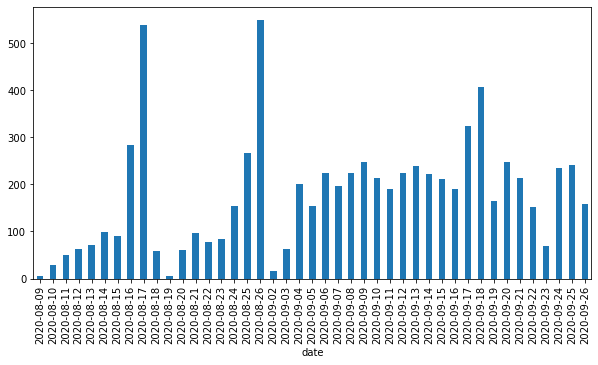

In [31]:
%%time

df_pd = df_sample.toPandas().sort_values('date', inplace=False)

day_groups = df_pd.groupby(df_pd['date'])['date'].count()

day_groups.plot(kind='bar',figsize=(10,5),legend=None)

In [32]:
%%time

df_time_converted = df_dated.withColumn('user_followers_count', F.col('user_followers_count').cast(T.IntegerType())).withColumn('f22_sentiment_compound', F.col('f22_sentiment_compound').cast(T.FloatType()))

df_has_scores = df_time_converted.where(F.col('user_followers_count') > 0).where(F.col('f22_sentiment_compound') != 0)

print(f'Has followers and compound score: {df_has_scores.count()}')

df_com_score = df_has_scores.withColumn('f22_compound_score', F.col('user_followers_count') * F.col('f22_sentiment_compound'))

Has followers and compound score: 4810317
Wall time: 22.2 s


In [33]:
%%time

from ams.services import dataframe_services

tag = 'learning_prep_drop'

sent_drop_path = Path(constants.DATA_PATH, twitter_folder, tag)

dataframe_services.persist_dataframe_as_csv(df=df_com_score, output_drop_folder_path=sent_drop_path, prefix=tag, num_output_files=1)

C:\Users\Chris\workspaces\data\twitter\learning_prep_drop\learning_prep_drop_2020-09-29_18-15-09-909.53
Wall time: 5min 44s
